In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

import healpy as hp 
import pymaster as nmt
from astropy.io import fits

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
nside = 512
lmax = 3*nside -1
freq = ['30','40','85','95','145','155','220','270']

In [3]:
mask_file = '/global/homes/k/kp22/lynx/data/interim/n0512.h5'
with h5py.File(mask_file, 'r') as f:
    mask = f['ns0512/apodized/basic'][...]
    mask_binary = f['ns0512/binary'][...]

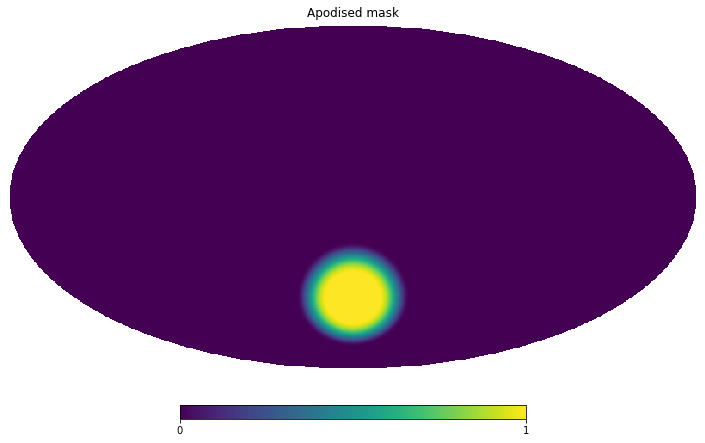

In [4]:
hp.mollview(mask,sub=121,title="Apodised mask")

# Reading in the input and recovered maps and respective power spectra

In [5]:
#The mean_maps.h5 contains a record of shape (3, 10, 8, 2, 3145728).
#Components (CMB,Dust,Sync) = 3
#nmc=5
#n_freq = 8

In [6]:
data_file = '/global/homes/k/kp22/lynx/data/interim/mean_maps.h5'

In [7]:
with h5py.File(data_file, 'r') as f:
    data = f['maps/monte_carlo/data'][...]

OSError: Unable to open file (unable to open file: name = '/global/homes/k/kp22/lynx/data/interim/mean_maps.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
data.shape

In [ ]:
def factor_CMB_to_RJ(nu):
    x = 0.0176086761 * nu
    ex = np.exp(x)
    factor = ex * (x / (ex - 1)) ** 2
    return factor

In [ ]:
cmb_map_in = np.nan_to_num(data[0,:,3])*mask_binary
dust_map_in = np.nan_to_num(data[1,:,7])*mask_binary*factor_CMB_to_RJ(270)
sync_map_in = np.nan_to_num(data[2,:,0])*mask_binary*factor_CMB_to_RJ(30)

In [ ]:
# setup binning
step = 35
ell_ini = np.arange(30,500,step)
ell_end = np.arange(ell_ini[1]-1,ell_ini[-1]+step+1,step)
b = nmt.NmtBin.from_edges(ell_ini,ell_end, is_Dell=True)
eff_ells = b.get_effective_ells()

In [ ]:
# read workspace
wsp00 = nmt.NmtWorkspace()
wsp00.read_from("/global/homes/k/kp22/lynx/data/interim/basic_wsp.fits")

In [ ]:
def get_spectrum(QU_maps, mask, b, wsp00):
    #Takes Q and U maps and returns BB power spectrum
    f_2 = nmt.NmtField(mask, [QU_maps[0],QU_maps[1]])
    return nmt.compute_full_master(f_2, f_2, b, workspace=wsp00)[3]

In [ ]:
cmb_ps_in = np.zeros(shape=(len(cmb_map_in),len(eff_ells)))

for i in range(5):
    cmb_ps_in[i] = get_spectrum([cmb_map_in[i,0],cmb_map_in[i,1]],mask,b,wsp00)
    

In [ ]:
dust_ps_in = np.zeros(shape=(len(cmb_map_in),len(eff_ells)))

for i in range(5):
    dust_ps_in[i] = get_spectrum([dust_map_in[i,0],dust_map_in[i,1]],mask,b,wsp00)
 

In [ ]:
sync_ps_in = np.zeros(shape=(len(cmb_map_in),len(eff_ells)))

for i in range(5):
    sync_ps_in[i] = get_spectrum([sync_map_in[i,0],sync_map_in[i,1]],mask,b,wsp00)
 

In [ ]:
cmb_ps_in_mean = np.sum(cmb_ps_in,axis=0)/ len(cmb_ps_in)
dust_ps_in_mean = np.sum(dust_ps_in,axis=0)/ len(dust_ps_in)
sync_ps_in_mean = np.sum(sync_ps_in,axis=0)/ len(sync_ps_in)

# Recovered maps and power spectra

In [ ]:
outpath = '/global/homes/k/kp22/lynx/data/interim/cmbs4_hm.h5'
f = h5py.File(outpath, 'r')
comp_sep = f['comp_sep_validation/one']

In [ ]:
cmb_map_rec = np.array(comp_sep['cmb_T_bar'])[::2]
dust_map_rec = np.array(comp_sep['dustmbb_T_bar'])[::2]
sync_map_rec = np.array(comp_sep['syncpl_T_bar'])[::2]

In [ ]:
power_spectra = comp_sep['spectra/linear_lmin30lmax383']

In [ ]:
cmb_ps_rec = np.array(power_spectra['cmb'])[:,3,:]
dust_ps_rec = np.array(power_spectra['dustmbb'])[:,3,:]
sync_ps_rec = np.array(power_spectra['syncpl'])[:,3,:]

In [ ]:
cmb_ps_rec_mean = np.sum(cmb_ps_rec,axis=0)/ len(cmb_ps_rec)
dust_ps_rec_mean = np.sum(dust_ps_rec,axis=0)/ len(dust_ps_rec)
sync_ps_rec_mean = np.sum(sync_ps_rec,axis=0)/ len(sync_ps_rec)

# Plotting maps

In [ ]:
def plot_map(map,sub,title,min,max):
    lon_center, lat_center, psi_center = 0, -45, 360/4
    xsize = 3*512
    reso  = 2.1
    az_dθφ = hp.azeqview(map,
    rot=(lon_center,lat_center, 360/4),
    lamb=True, # lamb = false makes Azimuthal equidistant projection
    reso=reso, title=title,
    min=min, max=max,
    xsize=xsize, cmap='jet',
    sub=sub,
    return_projected_map=True
    )

In [ ]:
plot_map(cmb_map_in[0,0],sub=131,title="Input CMB Q-Pol",min=-5e-7,max=5e-7)
plot_map(cmb_map_rec[0,0],sub=132,title="Recovered CMB Q-Pol",min=-5e-7,max=5e-7)
plot_map(cmb_map_in[0,0]-cmb_map_rec[0,0],sub=133,title="Residual plot",min=-5e-7,max=5e-7)

In [ ]:
plot_map(cmb_map_in[0,1],sub=131,title="Input CMB U-Pol",min=-5e-7,max=5e-7)
plot_map(cmb_map_rec[0,1],sub=132,title="Recovered CMB U-Pol",min=-5e-7,max=5e-7)
plot_map(cmb_map_in[0,1]-cmb_map_rec[0,1],sub=133,title="Residual plot",min=-5e-7,max=5e-7)

In [ ]:
plot_map(dust_map_in[0,1],sub=131,title="Input Dust U-Pol",min=-5e-7,max=5e-7)
plot_map(dust_map_rec[0,1],sub=132,title="Recovered Dust U-Pol",min=-5e-7,max=5e-7)
plot_map(dust_map_in[0,1]-dust_map_rec[0,1],sub=133,title="Residual plot",min=-5e-7,max=5e-7)

In [ ]:
plot_map(sync_map_in[1,1],sub=131,title="Input Sync U-Pol",min=-5e-6,max=5e-6)
plot_map(sync_map_rec[1,1],sub=132,title="Recovered Sync U-Pol",min=-5e-6,max=5e-6)
plot_map(sync_map_in[1,1]-sync_map_rec[1,1],sub=133,title="Residual plot",min=-5e-6,max=5e-6)

# Plotting the Estimated Power Spectrum

In [ ]:
plt.figure()
plt.plot(eff_ells,cmb_ps_rec_mean,label=r"$Rec. C_\ell^{BB}$ for CMB")
plt.plot(eff_ells,cmb_ps_in_mean,label=r"Input $C_\ell^{BB}$ for CMB")
for i in range(5):
    plt.plot(eff_ells,cmb_ps_rec[i],alpha=0.2)
    plt.plot(eff_ells,cmb_ps_in[i],alpha=0.2)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel(r'$D_\ell$', fontsize=16)
plt.loglog()
plt.xlim(40,250)
plt.legend(loc='upper left', fontsize=16, labelspacing=0.1)

In [ ]:
plt.figure()
plt.plot(eff_ells,dust_ps_rec_mean,label=r"$Rec. C_\ell^{BB}$ for Dust at 270GHz")
plt.plot(eff_ells,dust_ps_in_mean,label=r"Input $C_\ell^{BB}$ for Dust at 270GHz")
for i in range(5):
    plt.plot(eff_ells,dust_ps_rec[i],alpha=0.2)
    plt.plot(eff_ells,dust_ps_in[i],alpha=0.2)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel(r'$D_\ell$', fontsize=16)
plt.loglog()
plt.xlim(40,250)
plt.ylim(1e-15,1e-13)
plt.legend(loc='upper left', fontsize=16, labelspacing=0.1)

In [ ]:
plt.figure()
plt.plot(eff_ells,sync_ps_rec_mean,label=r"$Rec. C_\ell^{BB}$ for Sync at 30GHz")
plt.plot(eff_ells,sync_ps_in_mean,label=r"Input $C_\ell^{BB}$ for Sync at 30GHz")
for i in range(5):
    plt.plot(eff_ells,sync_ps_rec[i],alpha=0.2)
    plt.plot(eff_ells,sync_ps_in[i],alpha=0.2)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel(r'$D_\ell$', fontsize=16)
plt.loglog()
plt.xlim(40,250)
plt.ylim(1e-11,1e-13)
plt.legend(loc='upper left', fontsize=16, labelspacing=0.1)

In [ ]:
plt.figure()
plt.plot(eff_ells,cmb_ps_in_mean,'b',label=r"Input $D_\ell^{BB}$ for CMB")
plt.plot(eff_ells,dust_ps_in_mean,'g',label=r"Input $D_\ell^{BB}$ for Dust")
plt.plot(eff_ells,sync_ps_in_mean,'y',label=r"Input $D_\ell^{BB}$ for Sync")
plt.plot(eff_ells,cmb_ps_rec_mean,'b--',label=r"$D_\ell^{BB}$ for CMB")
plt.plot(eff_ells,dust_ps_rec_mean,'g--',label=r"$D_\ell^{BB}$ for Dust")
plt.plot(eff_ells,sync_ps_rec_mean,'y--',label=r"$D_\ell^{BB}$ for Sync")

plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi[\mu K^2]$', fontsize=16)

plt.loglog()
plt.xlim(40,250)
plt.ylim(1e-11,1e-17)
plt.legend(loc='upper left', fontsize=16, labelspacing=0.1)